In [1]:
from __future__ import annotations

import copy
import math
import random
from dataclasses import dataclass
from typing import Tuple, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
def set_seed(seed: int = 1337) -> None:
    """Ensure reproducible pseudo-randomness across numpy, torch, and python."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


@dataclass
class BurgersConfig:
    """Configuration bundle for the Burgers' cross-resolution benchmark."""
    grid_size: int = 64
    viscosity: float = 0.05
    horizon: float = 1.0
    time_step: float = 5e-4
    modes: int = 5
    samples: int = 50

    # Data splits
    batch_size: int = 10
    train_frac: float = 0.6
    val_frac: float = 0.2  # test_frac = 1 - train_frac - val_frac

    # Training budget control (fairness)
    fair_total_updates: int = 6000  # approximate target gradient updates per model

    # OLFM-style training config
    olfm_fm_epochs: int = 300
    olfm_finetune_epochs: int = 100
    olfm_patience: int = 20

    # Seeds (overridden per outer seed in main)
    dataset_seed: int = 1337
    split_seed: int = 1338
    model_seed: int = 1339

    # Multi-seed experiment
    num_seeds: int = 3

    # Hyperparameter search
    hp_trials_per_model: int = 1

    # Cross-resolution target grid
    cross_grid_size: int = 128


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(1337)

## **Data generation**

In [3]:
def generate_initial_condition(
    nx: int,
    num_modes: int = 5,
    rng: np.random.Generator | None = None,
) -> np.ndarray:
    """Sample a smooth periodic initial condition with unit amplitude on [0, 1)."""
    x = np.linspace(0, 1, nx, endpoint=False)
    u0 = np.zeros_like(x, dtype=np.float64)
    if rng is None:
        rng = np.random.default_rng()
    for k in range(1, num_modes + 1):
        decay = 1.0 / (k ** 2)
        a_k = rng.normal(0.0, decay)
        b_k = rng.normal(0.0, decay)
        u0 += a_k * np.cos(2 * np.pi * k * x) + b_k * np.sin(2 * np.pi * k * x)
    u0 -= u0.mean()
    max_amp = np.max(np.abs(u0))
    if max_amp > 1e-8:
        u0 /= max_amp
    return u0


def simulate_burgers(
    u0: np.ndarray,
    *,
    horizon: float,
    dt: float,
    nu: float,
) -> np.ndarray:
    """Integrate viscous Burgers' equation using a pseudospectral explicit Euler scheme."""
    nx = u0.size
    omega = 2 * np.pi * np.fft.rfftfreq(nx, d=1.0 / nx)
    u_hat = np.fft.rfft(u0)
    nsteps = int(horizon / dt)
    cutoff = nx // 3

    for _ in range(nsteps):
        u_phys = np.fft.irfft(u_hat, n=nx)
        u_x_phys = np.fft.irfft(1j * omega * u_hat, n=nx)
        conv_hat = np.fft.rfft(-u_phys * u_x_phys)
        conv_hat[cutoff:] = 0
        diff_hat = -nu * (omega ** 2) * u_hat

        u_hat = u_hat + dt * (conv_hat + diff_hat)
        u_hat[cutoff:] = 0

    return np.fft.irfft(u_hat, n=nx)


def build_dataset(cfg: BurgersConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Generate paired initial/final states for the Burgers benchmark."""
    initials: List[np.ndarray] = []
    finals: List[np.ndarray] = []
    rng = np.random.default_rng(seed=cfg.dataset_seed)
    for _ in range(cfg.samples):
        u0 = generate_initial_condition(cfg.grid_size, cfg.modes, rng=rng)
        uT = simulate_burgers(
            u0,
            horizon=cfg.horizon,
            dt=cfg.time_step,
            nu=cfg.viscosity,
        )
        initials.append(u0)
        finals.append(uT)
    return np.asarray(initials), np.asarray(finals)


def make_splits(
    cfg: BurgersConfig,
    initials: np.ndarray,
    finals: np.ndarray,
):
    """Train/val/test split with fixed random seed."""
    N = initials.shape[0]
    rng = np.random.default_rng(seed=cfg.split_seed)
    indices = rng.permutation(N)

    n_train = int(cfg.train_frac * N)
    n_val = int(cfg.val_frac * N)
    n_test = N - n_train - n_val

    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]

    train_u0, train_uT = initials[train_idx], finals[train_idx]
    val_u0, val_uT = initials[val_idx], finals[val_idx]
    test_u0, test_uT = initials[test_idx], finals[test_idx]

    return train_u0, train_uT, val_u0, val_uT, test_u0, test_uT

## **Spectral encoder / decoder**

In [4]:
def encode_field(u_phys: np.ndarray) -> np.ndarray:
    """Pack a real-valued field (shape [..., Nx]) into concatenated rFFT coefficients."""
    u = np.asarray(u_phys)
    if u.ndim == 1:
        u = u[None, :]
    batch, nx = u.shape
    fft_coeffs = np.fft.rfft(u, axis=1)
    halfM = fft_coeffs.shape[1]

    latent = np.zeros((batch, nx), dtype=np.float32)
    latent[:, 0] = fft_coeffs[:, 0].real

    if nx % 2 == 0:
        latent[:, -1] = fft_coeffs[:, halfM - 1].real
        max_freq = halfM - 1
    else:
        max_freq = halfM

    for k in range(1, max_freq):
        real_idx = 2 * (k - 1) + 1
        imag_idx = 2 * (k - 1) + 2
        latent[:, real_idx] = fft_coeffs[:, k].real
        latent[:, imag_idx] = fft_coeffs[:, k].imag

    return latent if batch > 1 else latent[0]


def decode_latent(latent: np.ndarray) -> np.ndarray:
    """Recover a real-valued field from concatenated spectral coefficients."""
    z = np.asarray(latent, dtype=np.float32)
    if z.ndim == 1:
        z = z[None, :]
    batch, nx = z.shape
    halfM = nx // 2 + 1

    fft_coeffs = np.zeros((batch, halfM), dtype=np.complex64)
    fft_coeffs[:, 0] = z[:, 0].astype(np.float32) + 0j

    if nx % 2 == 0:
        fft_coeffs[:, halfM - 1] = z[:, -1].astype(np.float32) + 0j
        max_freq = halfM - 1
    else:
        max_freq = halfM

    for k in range(1, max_freq):
        real_idx = 2 * (k - 1) + 1
        imag_idx = 2 * (k - 1) + 2
        fft_coeffs[:, k] = z[:, real_idx] + 1j * z[:, imag_idx]

    u_reconstructed = np.fft.irfft(fft_coeffs, n=nx, axis=1)
    return u_reconstructed if batch > 1 else u_reconstructed[0]

## **Spectral latent model**

In [5]:
class TinyMLP(nn.Module):
    """Frequency / time modulator for spectral multipliers."""

    def __init__(self, hidden: int = 48) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )

    def forward(
        self,
        kappa: torch.Tensor,
        t: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            kappa: normalized frequencies, shape [B, M, 1]
            t: times, shape [B, M, 1]
        Returns:
            Tuple of real/imag multipliers (each [B, M]).
        """
        x = torch.cat([kappa, t], dim=-1)
        out = self.net(x)
        return out[..., 0], out[..., 1]


class SpectralOperatorInvariant(nn.Module):
    """Resolution-aware spectral vector field operating on packed latent vectors."""

    def __init__(
        self,
        nx: int,
        lip_cap: float = 1.5,
        hidden: int = 48,
    ) -> None:
        super().__init__()
        self.nx = nx
        self.halfM = nx // 2 + 1
        self.lip_cap = lip_cap
        self.A_mlp = TinyMLP(hidden)
        self.B_mlp = TinyMLP(hidden)
        self.sigma = nn.Tanh()  # 1-Lipschitz non-linearity
        self.register_buffer("freq_mask", torch.ones(self.halfM, dtype=torch.float32))

    # ------------------------------ packing helpers ------------------------------ #

    def _pack(self, z: torch.Tensor) -> torch.Tensor:
        """Pack real/imag latent z [B, Nx] into complex FFT coeffs [B, halfM]."""
        batch, _ = z.shape
        fft = torch.zeros(batch, self.halfM, dtype=torch.complex64, device=z.device)
        fft[:, 0] = z[:, 0].to(torch.complex64)

        if self.nx % 2 == 0:
            fft[:, -1] = z[:, -1].to(torch.complex64)
            max_freq = self.halfM - 1
        else:
            max_freq = self.halfM

        for k in range(1, max_freq):
            real_idx = 2 * (k - 1) + 1
            imag_idx = 2 * (k - 1) + 2
            fft[:, k] = torch.complex(z[:, real_idx], z[:, imag_idx])
        return fft

    def _unpack(self, fft: torch.Tensor) -> torch.Tensor:
        """Unpack complex FFT coeffs [B, halfM] back to latent z [B, Nx]."""
        batch, _ = fft.shape
        z = torch.zeros(batch, self.nx, dtype=torch.float32, device=fft.device)
        z[:, 0] = fft[:, 0].real

        if self.nx % 2 == 0:
            z[:, -1] = fft[:, -1].real
            max_freq = self.halfM - 1
        else:
            max_freq = self.halfM

        for k in range(1, max_freq):
            real_idx = 2 * (k - 1) + 1
            imag_idx = 2 * (k - 1) + 2
            z[:, real_idx] = fft[:, k].real
            z[:, imag_idx] = fft[:, k].imag
        return z

    # ------------------------------ forward pass ------------------------------ #

    def forward(self, z: torch.Tensor, t_scalar: torch.Tensor) -> torch.Tensor:
        """
        Args:
            z: packed latent states [B, Nx]
            t_scalar: times in [0, 1], shape [B] or [1]
        Returns:
            Spectral velocities with the same shape as the input latent.
        """
        z = z.to(torch.float32)
        batch, _ = z.shape

        Z = self._pack(z)

        k = torch.arange(self.halfM, device=z.device).float()
        denom = max(self.halfM - 1, 1) + 1e-8  # avoid divide-by-zero for tiny grids
        kappa = (k / denom).view(1, self.halfM, 1).repeat(batch, 1, 1)

        if t_scalar.ndim == 1:
            t = t_scalar.view(-1, 1, 1).to(torch.float32).repeat(1, self.halfM, 1)
        else:
            t = t_scalar.to(torch.float32).view(-1, 1, 1).repeat(1, self.halfM, 1)

        Ar, Ai = self.A_mlp(kappa, t)
        Br, Bi = self.B_mlp(kappa, t)

        cap = torch.tensor(self.lip_cap, dtype=torch.float32, device=z.device)
        A = torch.complex(torch.tanh(Ar) * cap, torch.tanh(Ai) * cap)
        Bm = torch.complex(torch.tanh(Br) * cap, torch.tanh(Bi) * cap)

        linear = A * Z * self.freq_mask.view(1, -1)

        u_phys = torch.fft.irfft(Z, n=self.nx, dim=1)
        v_phys = self.sigma(u_phys)
        nonlinear = Bm * torch.fft.rfft(v_phys, n=self.nx, dim=1) * self.freq_mask.view(1, -1)

        return self._unpack(linear + nonlinear)


def lipschitz_penalty(
    model: SpectralOperatorInvariant,
    target_cap: float = 1.5,
    weight: float = 1e-3,
) -> torch.Tensor:
    """Penalty encouraging spectral multipliers to stay within the Lipschitz cap."""
    penalty = torch.tensor(0.0, device=next(model.parameters()).device)
    for mlp in (model.A_mlp.net, model.B_mlp.net):
        for param in mlp.parameters():
            penalty = penalty + torch.relu(param.abs().mean() - target_cap / 2.0)
    return weight * penalty


def project_constraints_latent(z: torch.Tensor) -> torch.Tensor:
    """Enforce zero mean in physical space by zeroing the DC component."""
    z = z.clone()
    z[:, 0] = 0.0
    return z


def count_parameters(model: nn.Module) -> int:
    """Count trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## **Integration and train**

In [6]:
def integrate_final_torch(
    model: SpectralOperatorInvariant,
    z0: torch.Tensor,
    steps: int = 100,
) -> torch.Tensor:
    """Integrate the learned latent ODE from t=0 to t=1."""
    model.eval()
    with torch.no_grad():
        z = z0.clone()
        dt = 1.0 / steps
        time = 0.0
        for _ in range(steps):
            t_tensor = torch.full(
                (z.shape[0],),
                time,
                dtype=torch.float32,
                device=z.device,
            )
            z = z + dt * model(z, t_tensor)
            z = project_constraints_latent(z)
            time += dt
    return z


def integrate_trajectory_numpy(
    model: SpectralOperatorInvariant,
    z0: torch.Tensor,
    steps: int = 100,
) -> np.ndarray:
    """Integrate the latent ODE and return the full trajectory as numpy array."""
    model.eval()
    z = z0.clone()
    dt = 1.0 / steps
    traj = [z.detach().cpu().numpy()]
    time = 0.0
    for _ in range(steps):
        t_tensor = torch.full(
            (z.shape[0],),
            time,
            dtype=torch.float32,
            device=z.device,
        )
        z = z + dt * model(z, t_tensor)
        z = project_constraints_latent(z)
        time += dt
        traj.append(z.detach().cpu().numpy())
    return np.asarray(traj)


def train_flow_matching(
    model: SpectralOperatorInvariant,
    optimizer: torch.optim.Optimizer,
    z0: torch.Tensor,
    zT: torch.Tensor,
    epochs: int = 200,
    batch_size: int = 10,
) -> List[float]:
    """Pure flow-matching training."""
    model.train()
    n = z0.shape[0]
    losses: List[float] = []

    for epoch in range(epochs):
        perm = torch.randperm(n, device=z0.device)
        running_loss = 0.0
        n_batches = 0

        for start in range(0, n, batch_size):
            idx = perm[start:start + batch_size]
            z0_b, zT_b = z0[idx], zT[idx]

            t = torch.rand(len(idx), device=z0.device)
            t_col = t.unsqueeze(1)
            zt = (1.0 - t_col) * z0_b + t_col * zT_b
            target_v = zT_b - z0_b

            pred_v = model(zt, t)
            loss = torch.mean((pred_v - target_v) ** 2) + lipschitz_penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

        avg_loss = running_loss / max(1, n_batches)
        losses.append(avg_loss)

        if (epoch + 1) == 1 or (epoch + 1) % 20 == 0:
            print(f"[Burgers-OLFM] FM Epoch {epoch + 1:03d}/{epochs}, loss={avg_loss:.4e}")

    return losses


def finetune_with_rollout(
    model: SpectralOperatorInvariant,
    optimizer: torch.optim.Optimizer,
    z0_train: torch.Tensor,
    zT_train: torch.Tensor,
    z0_val: torch.Tensor,
    zT_val: torch.Tensor,
    epochs: int = 100,
    batch_size: int = 10,
    steps: int = 20,
    patience: int = 20,
) -> Dict[str, List[float]]:
    """Fine tune OLFM with rollout loss and early stopping on validation MSE."""
    model.train()
    n = z0_train.shape[0]
    dt = 1.0 / steps
    mse_loss = nn.MSELoss()

    history: Dict[str, List[float]] = {
        "train_fm": [],
        "train_rollout": [],
        "val_mse": [],
        "best_val": [],
    }

    best_val = float("inf")
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        permutation = torch.randperm(n, device=z0_train.device)
        running_fm = 0.0
        running_roll = 0.0
        n_batches = 0

        for start in range(0, n, batch_size):
            idx = permutation[start:start + batch_size]
            z0_b = z0_train[idx]
            zT_b = zT_train[idx]

            # Flow matching term
            t_batch = torch.rand(z0_b.shape[0], device=z0_b.device)
            t_col = t_batch.unsqueeze(1)
            zt_batch = (1.0 - t_col) * z0_b + t_col * zT_b
            target_velocity = zT_b - z0_b
            loss_fm = torch.mean((model(zt_batch, t_batch) - target_velocity) ** 2)

            # Rollout term
            z_pred = z0_b.clone()
            time = 0.0
            for _ in range(steps):
                t_tensor = torch.full(
                    (z_pred.shape[0],),
                    time,
                    dtype=torch.float32,
                    device=z0_b.device,
                )
                z_pred = z_pred + dt * model(z_pred, t_tensor)
                z_pred = project_constraints_latent(z_pred)
                time += dt

            loss_rollout = torch.mean((z_pred - zT_b) ** 2)
            loss = loss_fm + 0.1 * loss_rollout + lipschitz_penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_fm += loss_fm.item()
            running_roll += loss_rollout.item()
            n_batches += 1

        avg_fm = running_fm / max(1, n_batches)
        avg_roll = running_roll / max(1, n_batches)
        history["train_fm"].append(avg_fm)
        history["train_rollout"].append(avg_roll)

        # Validation MSE via full integration
        model.eval()
        with torch.no_grad():
            z_pred_val = integrate_final_torch(model, z0_val, steps=50)
            val_mse = mse_loss(z_pred_val, zT_val).item()
        history["val_mse"].append(val_mse)

        if (epoch == 1) or (epoch % 10 == 0):
            print(
                f"[Burgers-OLFM] FT Epoch {epoch:03d}/{epochs}, "
                f"FM={avg_fm:.4e}, Roll={avg_roll:.4e}, val MSE={val_mse:.4e}"
            )

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"[Burgers-OLFM] Early stopping at epoch {epoch} with best val MSE {best_val:.4e}")
            break

        model.train()

    model.load_state_dict(best_state)
    history["best_val"].append(best_val)
    return history

In [7]:
def train_spectral_model(
    cfg: BurgersConfig,
    train_u0: np.ndarray,
    train_uT: np.ndarray,
    val_u0: np.ndarray,
    val_uT: np.ndarray,
    hidden: int = 48,
    lr: float = 1e-3,
    fm_epochs: int | None = None,
    finetune_epochs: int | None = None,
) -> Tuple[SpectralOperatorInvariant, Dict[str, List[float]]]:
    """Wrapper for Burgers spectral OLFM-style model."""
    if fm_epochs is None:
        fm_epochs = cfg.olfm_fm_epochs
    if finetune_epochs is None:
        finetune_epochs = cfg.olfm_finetune_epochs

    nx = cfg.grid_size
    z0_train = torch.tensor(encode_field(train_u0), dtype=torch.float32, device=DEVICE)
    zT_train = torch.tensor(encode_field(train_uT), dtype=torch.float32, device=DEVICE)
    z0_val = torch.tensor(encode_field(val_u0), dtype=torch.float32, device=DEVICE)
    zT_val = torch.tensor(encode_field(val_uT), dtype=torch.float32, device=DEVICE)

    model = SpectralOperatorInvariant(nx=nx, hidden=hidden).to(DEVICE)
    print(f"Burgers-OLFM params: {count_parameters(model)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("Training Burgers OLFM (flow matching stage)...")
    fm_losses = train_flow_matching(
        model,
        optimizer,
        z0_train,
        zT_train,
        epochs=fm_epochs,
        batch_size=cfg.batch_size,
    )

    print("Fine tuning Burgers OLFM with rollout and validation early stopping...")
    history_ft = finetune_with_rollout(
        model,
        optimizer,
        z0_train,
        zT_train,
        z0_val,
        zT_val,
        epochs=finetune_epochs,
        batch_size=cfg.batch_size,
        steps=20,
        patience=cfg.olfm_patience,
    )

    history: Dict[str, List[float]] = {
        "fm_loss": fm_losses,
        "train_fm": history_ft["train_fm"],
        "train_rollout": history_ft["train_rollout"],
        "val_mse": history_ft["val_mse"],
        "best_val": history_ft["best_val"],
    }
    return model, history


def train_spectral_with_search(
    cfg: BurgersConfig,
    train_u0: np.ndarray,
    train_uT: np.ndarray,
    val_u0: np.ndarray,
    val_uT: np.ndarray,
    total_epochs: int,
) -> Tuple[SpectralOperatorInvariant, Dict[str, List[float]], Dict]:
    """Hyperparameter search for Burgers spectral OLFM under a fixed epoch budget."""
    search_space = [
        {"hidden": 48, "lr": 1e-3, "fm_frac": 0.5},
        {"hidden": 64, "lr": 1e-3, "fm_frac": 0.7},
        {"hidden": 64, "lr": 5e-4, "fm_frac": 0.5},
    ]
    num_trials = min(cfg.hp_trials_per_model, len(search_space))
    if num_trials < len(search_space):
        candidates = random.sample(search_space, num_trials)
    else:
        candidates = search_space

    best_val = float("inf")
    best_model: SpectralOperatorInvariant | None = None
    best_hist: Dict[str, List[float]] | None = None
    best_hps: Dict | None = None

    for trial_idx, hps in enumerate(candidates):
        print(f"\n[Burgers-OLFM] Hyperparam trial {trial_idx + 1}/{num_trials}, hps={hps}")
        set_seed(cfg.model_seed + 100 * trial_idx)

        fm_epochs = max(1, int(total_epochs * hps["fm_frac"]))
        ft_epochs = max(1, total_epochs - fm_epochs)
        model, hist = train_spectral_model(
            cfg,
            train_u0,
            train_uT,
            val_u0,
            val_uT,
            hidden=hps["hidden"],
            lr=hps["lr"],
            fm_epochs=fm_epochs,
            finetune_epochs=ft_epochs,
        )
        current_val = hist["best_val"][-1]
        print(f"[Burgers-OLFM] Trial val MSE: {current_val:.4e}")
        if current_val < best_val:
            best_val = current_val
            best_model = model
            best_hist = hist
            best_hps = {**hps, "fm_epochs": fm_epochs, "ft_epochs": ft_epochs}

    assert best_model is not None and best_hist is not None and best_hps is not None
    print(f"\n[Burgers-OLFM] Selected hyperparameters: {best_hps}, best val MSE={best_val:.4e}")
    return best_model, best_hist, best_hps

## **Evaluation helpers**

In [8]:
def pad_field_to(u_low: np.ndarray, n_tgt: int) -> np.ndarray:
    """Zero-pad a physical field in Fourier space to a target resolution."""
    fft = np.fft.rfft(u_low)
    m_src = fft.shape[-1]
    m_tgt = n_tgt // 2 + 1
    fft_tgt = np.zeros(m_tgt, dtype=np.complex64)
    fft_tgt[:m_src] = fft[:m_src]  # copy existing modes
    return np.fft.irfft(fft_tgt, n=n_tgt)


def evaluate_low_resolution(
    model: SpectralOperatorInvariant,
    cfg: BurgersConfig,
    test_u0: np.ndarray,
    test_uT: np.ndarray,
    steps: int = 100,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Evaluate learned mapping on the original resolution."""
    model.to(DEVICE)
    model.eval()

    z0_test = torch.tensor(encode_field(test_u0), dtype=torch.float32, device=DEVICE)

    with torch.no_grad():
        z_pred = integrate_final_torch(model, z0_test, steps=steps)

    pred_latent = z_pred.cpu().numpy()
    pred_phys = decode_latent(pred_latent)  # [N, nx]

    mse_all = ((pred_phys - test_uT) ** 2).mean(axis=1)
    return mse_all, pred_phys, test_uT


def evaluate_cross_resolution(
    model_low: SpectralOperatorInvariant,
    cfg: BurgersConfig,
    test_u0_low: np.ndarray,
    steps: int,
    hidden: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Evaluate cross-resolution transfer 64 -> 128 using spectral zero-padding."""
    nx_high = cfg.cross_grid_size

    # Instantiate a high-resolution operator and copy weights
    model_high = SpectralOperatorInvariant(nx_high, hidden=hidden).to(DEVICE)
    state_dict = model_low.state_dict()
    if "freq_mask" in state_dict:
        # Drop old freq_mask due to shape mismatch
        del state_dict["freq_mask"]
    model_high.load_state_dict(state_dict, strict=False)

    # Zero out new high-frequency modes to avoid noise
    m_src = model_low.halfM
    with torch.no_grad():
        model_high.freq_mask[m_src:] = 0.0

    # Build high-resolution test dataset
    N = test_u0_low.shape[0]
    test_u0_high = np.zeros((N, nx_high), dtype=np.float64)
    test_uT_high_true = np.zeros_like(test_u0_high)

    for i in range(N):
        u0_low = test_u0_low[i]
        u0_high = pad_field_to(u0_low, nx_high)
        test_u0_high[i] = u0_high
        test_uT_high_true[i] = simulate_burgers(
            u0_high,
            horizon=cfg.horizon,
            dt=cfg.time_step,
            nu=cfg.viscosity,
        )

    latent_high = torch.tensor(encode_field(test_u0_high), dtype=torch.float32, device=DEVICE)
    with torch.no_grad():
        z_pred_high = integrate_final_torch(model_high, latent_high, steps=steps)

    pred_latent_high = z_pred_high.cpu().numpy()
    pred_phys_high = decode_latent(pred_latent_high)

    mse_all = ((pred_phys_high - test_uT_high_true) ** 2).mean(axis=1)
    return mse_all, pred_phys_high, test_uT_high_true, test_u0_high


def h1_norm(u: np.ndarray) -> float:
    """Compute the H1 norm of a periodic function u."""
    nx = u.size
    u_hat = np.fft.rfft(u)
    omega = 2 * np.pi * np.fft.rfftfreq(nx, d=1.0 / nx)
    u_x = np.fft.irfft(1j * omega * u_hat, n=nx)
    return float(np.sqrt(np.mean(u ** 2) + np.mean(u_x ** 2)))


def spectral_error(u_pred: np.ndarray, u_true: np.ndarray) -> float:
    """Compute relative error in the spectral domain."""
    u_pred_hat = np.fft.rfft(u_pred)
    u_true_hat = np.fft.rfft(u_true)
    return float(np.linalg.norm(u_pred_hat - u_true_hat) / np.linalg.norm(u_true_hat))


def get_spectrum_1d(u: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute 1D energy spectrum."""
    u_hat = np.fft.rfft(u)
    k = np.arange(u_hat.size)
    E_k = np.abs(u_hat) ** 2
    return k, E_k

## **Diagnostics and plotting**

In [9]:
def plot_training_curves(history: Dict[str, List[float]]) -> None:
    """Plot FM pretraining loss and fine-tuning metrics."""
    fm_loss = history.get("fm_loss", [])
    train_fm = history.get("train_fm", [])
    train_roll = history.get("train_rollout", [])
    val_mse = history.get("val_mse", [])

    if fm_loss:
        plt.figure(figsize=(8, 4))
        plt.plot(fm_loss, label="FM loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.title("Burgers OLFM flow-matching pretraining")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if train_fm and val_mse:
        plt.figure(figsize=(10, 4))
        plt.plot(train_fm, label="Fine-tune FM term")
        plt.plot(train_roll, label="Fine-tune rollout term")
        plt.plot(val_mse, label="Validation MSE")
        plt.xlabel("Fine-tune epoch")
        plt.ylabel("Loss")
        plt.title("Burgers OLFM fine-tuning and validation")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


def plot_mse_summary(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = [test_mses[k].mean() for k in names]
    stds = [test_mses[k].std() for k in names]
    x = np.arange(len(names))
    with plt.rc_context({
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.2,
        "axes.edgecolor": "0.3",
        "xtick.direction": "out",
        "ytick.direction": "out",
    }):
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.bar(
            x,
            means,
            yerr=stds,
            capsize=4,
            width=0.6,
            linewidth=0.8,
            edgecolor="0.2",
            alpha=0.9,
        )
        ax.set_xticks(x)
        ax.set_xticklabels(names)  
        ax.set_ylabel("Test MSE")
        ax.set_title("Test MSE (mean ± std)")
        ax.grid(axis="y")
        fig.tight_layout()
        plt.show()
        fig, ax = plt.subplots(figsize=(8, 4))

        bp = ax.boxplot(
            [test_mses[k] for k in names],
            labels=names,
            showmeans=True,
            meanline=True,
            patch_artist=True,
        )
        for box in bp["boxes"]:
            box.set(facecolor="0.9", edgecolor="0.3", linewidth=0.8)
        for median in bp["medians"]:
            median.set(color="0.2", linewidth=1.0)
        for whisker in bp["whiskers"]:
            whisker.set(color="0.4", linewidth=0.8)
        for cap in bp["caps"]:
            cap.set(color="0.4", linewidth=0.8)
        for mean in bp["means"]:
            mean.set(color="0.1", linewidth=1.0)

        ax.set_ylabel("Test MSE")
        ax.set_title("Test MSE distribution")
        ax.grid(axis="y")
        fig.tight_layout()
        plt.show()


def plot_mse_summary_log(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = [test_mses[k].mean() for k in names]
    stds = [test_mses[k].std() for k in names]

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names, rotation=15)
    plt.yscale("log")
    plt.ylabel("Test MSE (log scale)")
    plt.title("Test MSE summary (mean ± std, log scale)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_mse_summary_relative(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = np.array([test_mses[k].mean() for k in names])
    stds = np.array([test_mses[k].std() for k in names])

    base = means[0]
    rel_means = means / base
    rel_stds = stds / base

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, rel_means, yerr=rel_stds, capsize=5)
    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.xticks(x, names, rotation=15)
    plt.ylabel("MSE / MSE(first)")
    plt.title("Relative Test MSE (lower is better)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_field_comparisons_1d(
    cfg: BurgersConfig,
    test_u0_low: np.ndarray,
    test_uT_low: np.ndarray,
    pred_uT_low: np.ndarray,
    test_u0_high: np.ndarray,
    test_uT_high: np.ndarray,
    pred_uT_high: np.ndarray,
    sample_idx: int = 0,
) -> None:
    """Plot low-res and high-res true vs predicted fields for one sample."""
    x_low = np.linspace(0, 1, cfg.grid_size, endpoint=False)
    x_high = np.linspace(0, 1, cfg.cross_grid_size, endpoint=False)

    u0_low = test_u0_low[sample_idx]
    true_low = test_uT_low[sample_idx]
    pred_low = pred_uT_low[sample_idx]

    u0_high = test_u0_high[sample_idx]
    true_high = test_uT_high[sample_idx]
    pred_high = pred_uT_high[sample_idx]

    plt.figure(figsize=(10, 4))
    plt.plot(x_low, u0_low, "k--", label="Initial u0 (64)")
    plt.plot(x_low, true_low, "b-", label="True u(T) (64)")
    plt.plot(x_low, pred_low, "r--", label="Predicted u(T) (64)")
    plt.xlabel("Spatial coordinate x")
    plt.ylabel("u(x)")
    plt.title("Burgers: true vs predicted final field (64-grid)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(x_high, u0_high, "k--", label="Initial u0 (128)")
    plt.plot(x_high, true_high, "b-", label="True u(T) (128)")
    plt.plot(x_high, pred_high, "r--", label="Predicted u(T) (128)")
    plt.xlabel("Spatial coordinate x")
    plt.ylabel("u(x)")
    plt.title("Burgers: cross-resolution true vs predicted final field (128-grid)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_spectrum_comparison_1d(
    true_low: np.ndarray,
    pred_low: np.ndarray,
    true_high: np.ndarray,
    pred_high: np.ndarray,
) -> None:
    """Plot energy spectra for low-res and high-res true vs predicted fields."""
    k_true_low, E_true_low = get_spectrum_1d(true_low)
    k_pred_low, E_pred_low = get_spectrum_1d(pred_low)
    k_true_high, E_true_high = get_spectrum_1d(true_high)
    k_pred_high, E_pred_high = get_spectrum_1d(pred_high)

    plt.figure(figsize=(8, 4))
    plt.loglog(k_true_low[1:], E_true_low[1:], "b-", label="True (64)")
    plt.loglog(k_pred_low[1:], E_pred_low[1:], "b--", label="Pred (64)")
    plt.loglog(k_true_high[1:], E_true_high[1:], "r-", label="True (128)")
    plt.loglog(k_pred_high[1:], E_pred_high[1:], "r--", label="Pred (128)")
    plt.xlabel("Wavenumber k")
    plt.ylabel("Energy |u_hat(k)|^2")
    plt.title("Burgers: spectral comparison (64 and 128)")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Benchmark**

Device: cpu
Low-res grid: 64, high-res grid: 128

Outer seed 1/3 (base seed 0)
Generating Burgers dataset at low resolution...
Data shape: (50, 64)
Using 2000 epochs for Burgers-OLFM (~6000 gradient updates)

[Burgers-OLFM] Hyperparam trial 1/1, hps={'hidden': 48, 'lr': 0.001, 'fm_frac': 0.5}
Burgers-OLFM params: 5188
Training Burgers OLFM (flow matching stage)...
[Burgers-OLFM] FM Epoch 001/1000, loss=8.0190e+00
[Burgers-OLFM] FM Epoch 020/1000, loss=1.2373e+00
[Burgers-OLFM] FM Epoch 040/1000, loss=6.9596e-01
[Burgers-OLFM] FM Epoch 060/1000, loss=7.5711e-01
[Burgers-OLFM] FM Epoch 080/1000, loss=3.7235e-01
[Burgers-OLFM] FM Epoch 100/1000, loss=6.7884e-01
[Burgers-OLFM] FM Epoch 120/1000, loss=4.8783e-01
[Burgers-OLFM] FM Epoch 140/1000, loss=6.6494e-01
[Burgers-OLFM] FM Epoch 160/1000, loss=2.1593e-01
[Burgers-OLFM] FM Epoch 180/1000, loss=2.1949e-01
[Burgers-OLFM] FM Epoch 200/1000, loss=8.7127e-01
[Burgers-OLFM] FM Epoch 220/1000, loss=3.7953e-01
[Burgers-OLFM] FM Epoch 240/1000,

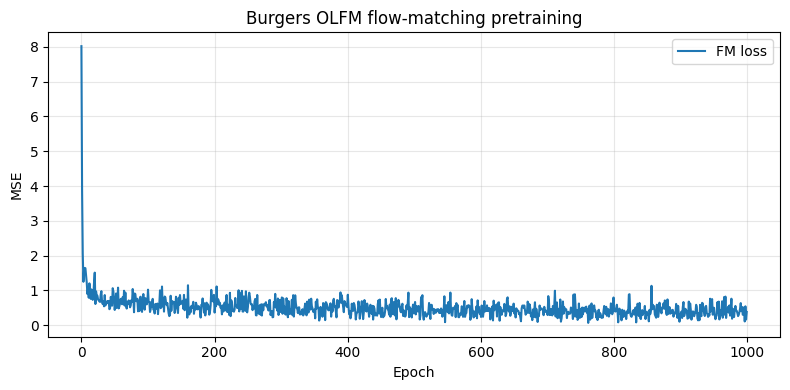

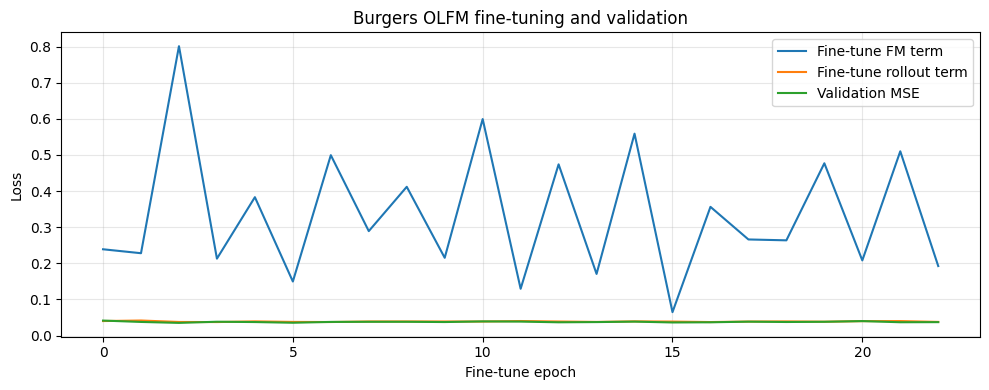

Plotting aggregated test MSE summary across resolutions (linear scale)...


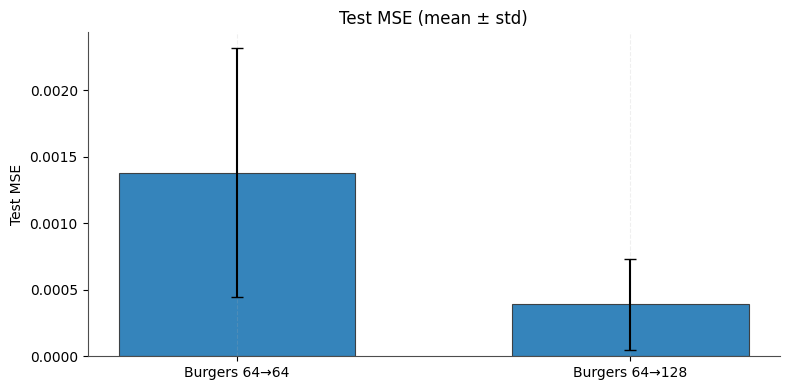

/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_10249/4121282646.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


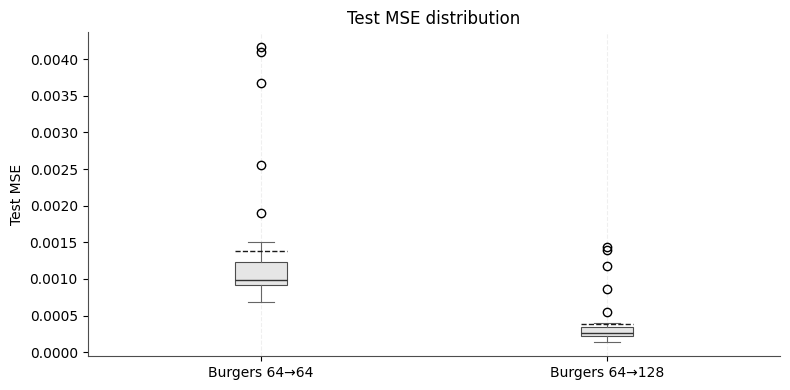

Plotting aggregated test MSE summary across resolutions (log scale)...


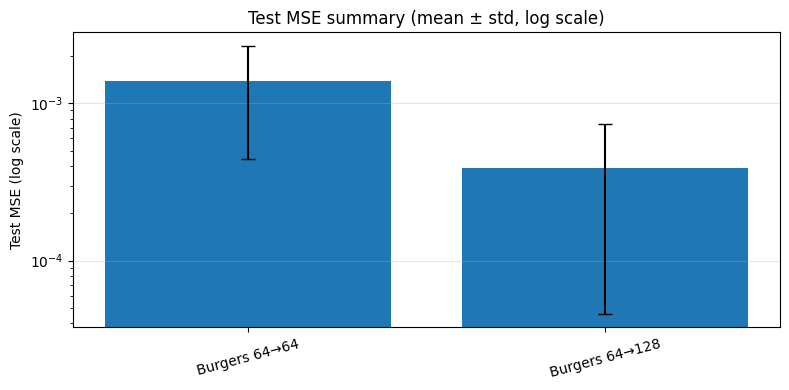

Plotting relative test MSE summary (normalised by low-res 64→64)...


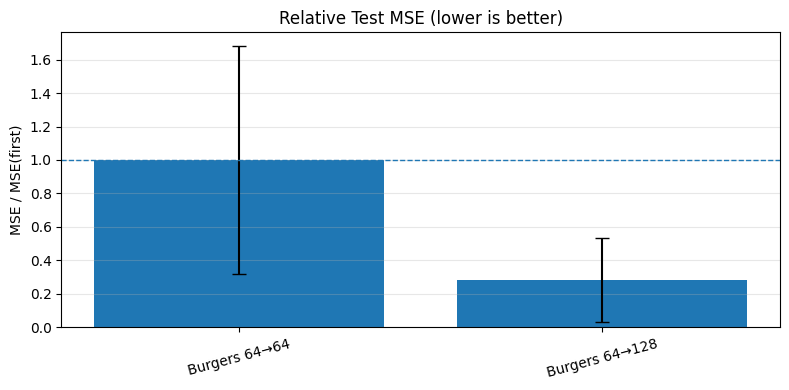

Plotting field comparisons for sample 0 (first seed)...


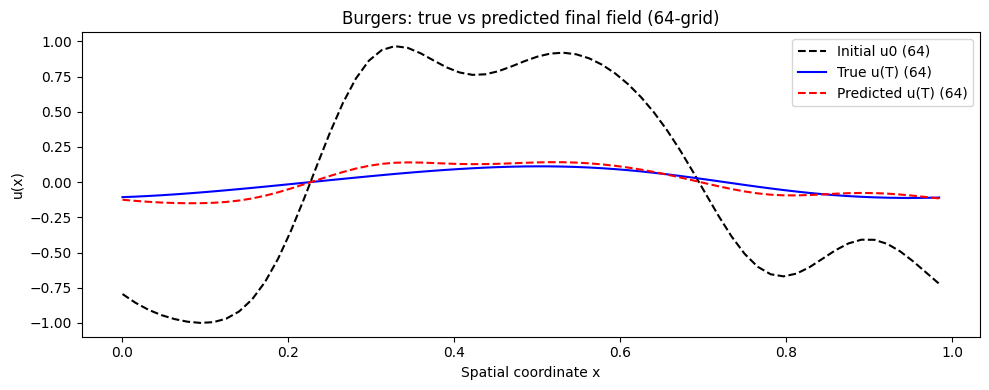

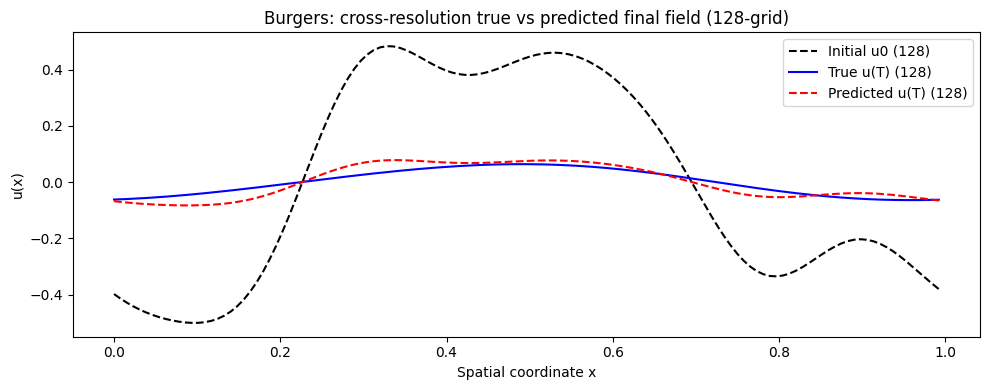

Plotting spectral comparison for sample 0 (first seed)...


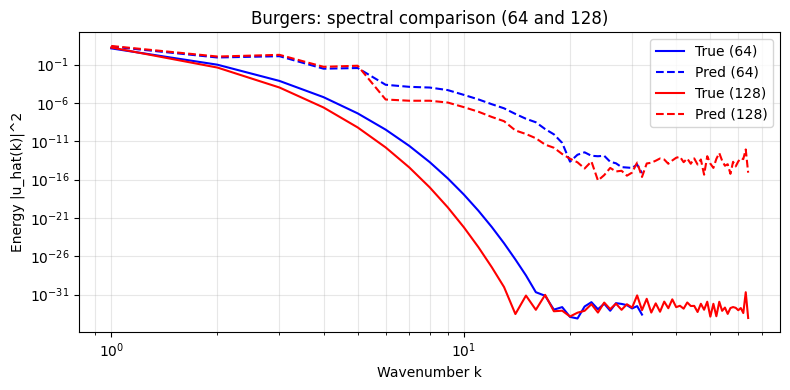


Diagnostics (first seed, sample 0):
  Low-res H1(true)=0.509, H1(pred)=0.859, spectral rel. error=5.510e-01
  High-res H1(true)=0.288, H1(pred)=0.492, spectral rel. error=5.189e-01


In [10]:
def main():
    cfg_base = BurgersConfig()
    print(f"Device: {DEVICE}")
    print(f"Low-res grid: {cfg_base.grid_size}, high-res grid: {cfg_base.cross_grid_size}")

    all_test_mses_low: List[np.ndarray] = []
    all_test_mses_cross: List[np.ndarray] = []

    history_first: Dict[str, List[float]] | None = None
    preds_low_first: np.ndarray | None = None
    test_u0_low_first: np.ndarray | None = None
    test_uT_low_first: np.ndarray | None = None
    preds_high_first: np.ndarray | None = None
    test_u0_high_first: np.ndarray | None = None
    test_uT_high_first: np.ndarray | None = None

    seed_values = list(range(cfg_base.num_seeds))

    for seed_idx, seed in enumerate(seed_values):
        print("\n" + "=" * 80)
        print(f"Outer seed {seed_idx + 1}/{len(seed_values)} (base seed {seed})")
        print("=" * 80)

        cfg = copy.deepcopy(cfg_base)
        cfg.dataset_seed = seed
        cfg.split_seed = seed + 100
        cfg.model_seed = seed + 200

        set_seed(cfg.model_seed)

        print("Generating Burgers dataset at low resolution...")
        initials, finals = build_dataset(cfg)
        print("Data shape:", initials.shape)

        (
            train_u0,
            train_uT,
            val_u0,
            val_uT,
            test_u0_low,
            test_uT_low,
        ) = make_splits(cfg, initials, finals)

        # Match training budget in number of gradient updates
        updates_per_epoch = math.ceil(train_u0.shape[0] / cfg.batch_size)
        total_epochs = max(1, cfg.fair_total_updates // max(1, updates_per_epoch))
        print(
            f"Using {total_epochs} epochs for Burgers-OLFM "
            f"(~{total_epochs * updates_per_epoch} gradient updates)"
        )

        # Train OLFM-style spectral operator with hyperparameter search
        model_low, hist_olfm, best_hps = train_spectral_with_search(
            cfg,
            train_u0,
            train_uT,
            val_u0,
            val_uT,
            total_epochs=total_epochs,
        )

        # Evaluate low-resolution mapping
        print("\nEvaluating low-resolution mapping (64 -> 64)...")
        mse_low_seed, pred_low_seed, true_low_seed = evaluate_low_resolution(
            model_low,
            cfg,
            test_u0_low,
            test_uT_low,
            steps=100,
        )

        # Evaluate cross-resolution mapping
        print("\nEvaluating cross-resolution mapping (64 -> 128)...")
        mse_cross_seed, pred_high_seed, true_high_seed, u0_high_seed = evaluate_cross_resolution(
            model_low,
            cfg,
            test_u0_low,
            steps=100,
            hidden=best_hps["hidden"],
        )

        all_test_mses_low.append(mse_low_seed)
        all_test_mses_cross.append(mse_cross_seed)

        # Store diagnostics from first seed
        if seed_idx == 0:
            history_first = hist_olfm
            preds_low_first = pred_low_seed
            test_u0_low_first = test_u0_low
            test_uT_low_first = true_low_seed
            preds_high_first = pred_high_seed
            test_u0_high_first = u0_high_seed
            test_uT_high_first = true_high_seed

        print("\nTest MSE for this seed:")
        print(f"  Burgers 64->64:   mean={mse_low_seed.mean():.4e} ± {mse_low_seed.std():.4e}")
        print(f"  Burgers 64->128:  mean={mse_cross_seed.mean():.4e} ± {mse_cross_seed.std():.4e}")

    aggregated_test_mses: Dict[str, np.ndarray] = {
        "Burgers 64→64": np.concatenate(all_test_mses_low, axis=0),
        "Burgers 64→128": np.concatenate(all_test_mses_cross, axis=0),
    }

    print("\n" + "=" * 80)
    print("Aggregated test MSE over all seeds (per sample, concatenated):")
    print("=" * 80)
    for name, mse_vals in aggregated_test_mses.items():
        print(f" {name:15s}: {mse_vals.mean():.4e} ± {mse_vals.std():.4e}")

    # Training curves for first seed
    if history_first is not None:
        print("\nPlotting training curves for first seed...")
        plot_training_curves(history_first)

    # Aggregate MSE plots
    print("Plotting aggregated test MSE summary across resolutions (linear scale)...")
    plot_mse_summary(aggregated_test_mses)

    print("Plotting aggregated test MSE summary across resolutions (log scale)...")
    plot_mse_summary_log(aggregated_test_mses)

    print("Plotting relative test MSE summary (normalised by low-res 64→64)...")
    plot_mse_summary_relative(aggregated_test_mses)

    # Field and spectrum plots from first seed
    if (
        preds_low_first is not None
        and test_u0_low_first is not None
        and test_uT_low_first is not None
        and preds_high_first is not None
        and test_u0_high_first is not None
        and test_uT_high_first is not None
    ):
        sample_idx = 0
        print(f"Plotting field comparisons for sample {sample_idx} (first seed)...")
        plot_field_comparisons_1d(
            cfg_base,
            test_u0_low_first,
            test_uT_low_first,
            preds_low_first,
            test_u0_high_first,
            test_uT_high_first,
            preds_high_first,
            sample_idx=sample_idx,
        )

        print(f"Plotting spectral comparison for sample {sample_idx} (first seed)...")
        true_low = test_uT_low_first[sample_idx]
        pred_low = preds_low_first[sample_idx]
        true_high = test_uT_high_first[sample_idx]
        pred_high = preds_high_first[sample_idx]
        plot_spectrum_comparison_1d(true_low, pred_low, true_high, pred_high)

        print("\nDiagnostics (first seed, sample 0):")
        print(
            f"  Low-res H1(true)={h1_norm(true_low):.3f}, "
            f"H1(pred)={h1_norm(pred_low):.3f}, "
            f"spectral rel. error={spectral_error(pred_low, true_low):.3e}"
        )
        print(
            f"  High-res H1(true)={h1_norm(true_high):.3f}, "
            f"H1(pred)={h1_norm(pred_high):.3f}, "
            f"spectral rel. error={spectral_error(pred_high, true_high):.3e}"
        )


if __name__ == "__main__":
    main()